# OASIS 2D IMAGES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import matplotlib.image as mpimg
import random


import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mild Demented

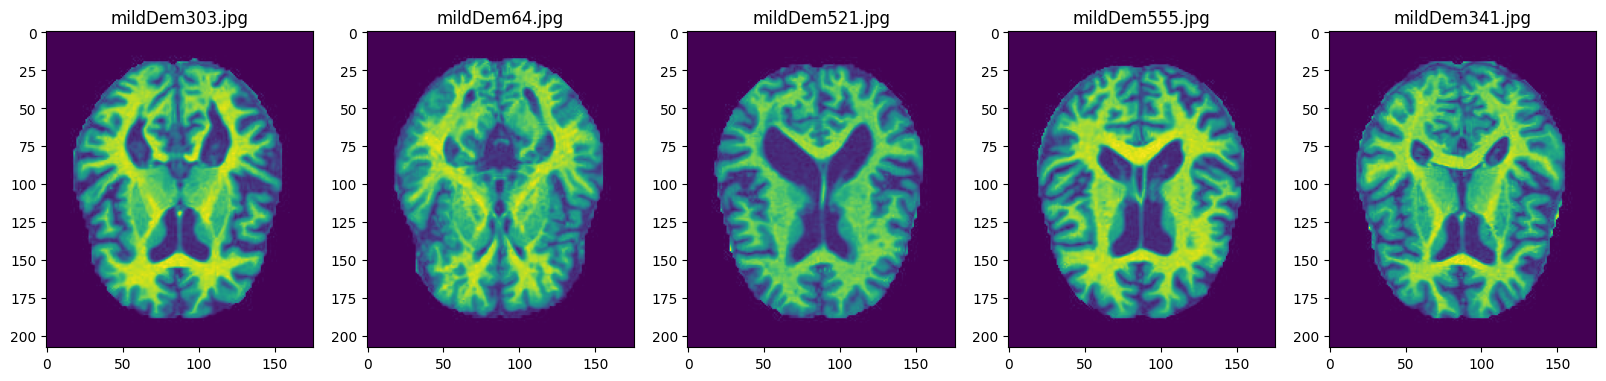

In [3]:

plt.figure(figsize=(20,20))
test_folder=r"/content/drive/MyDrive/Alzheimer_s Dataset/MildDemented"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)



## Moderate Demented

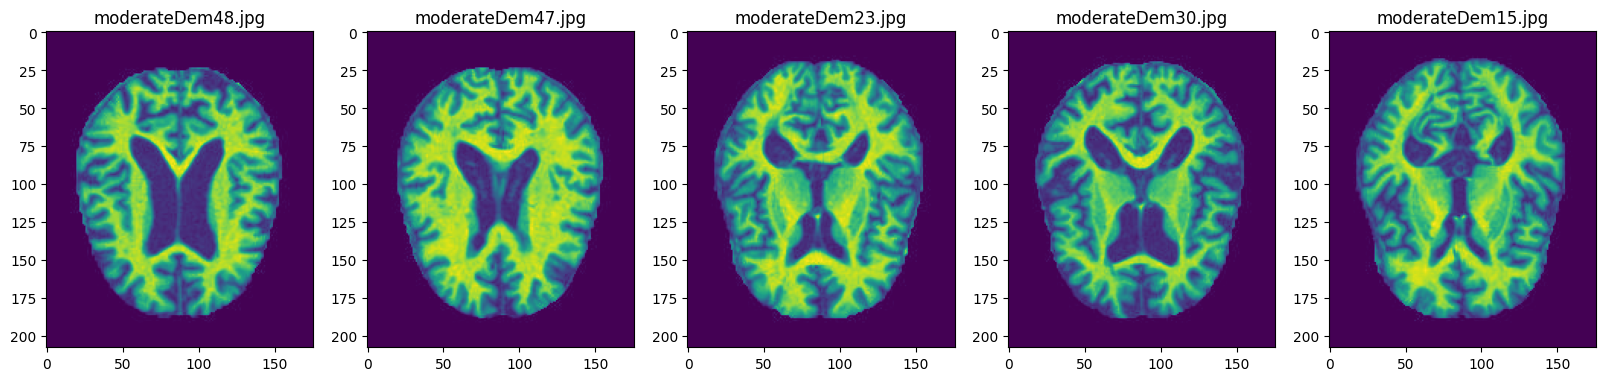

In [4]:
plt.figure(figsize=(20,20))
test_folder=r"/content/drive/MyDrive/Alzheimer_s Dataset/ModerateDemented"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## NonDemented

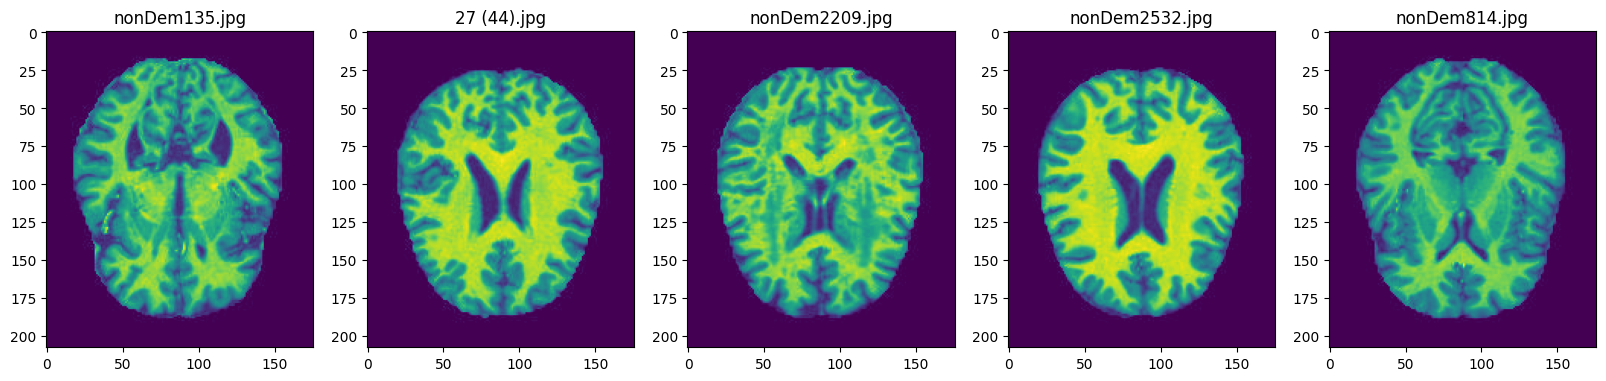

In [5]:
plt.figure(figsize=(20,20))
test_folder=r"/content/drive/MyDrive/Alzheimer_s Dataset/NonDemented"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## Very Mild Demented

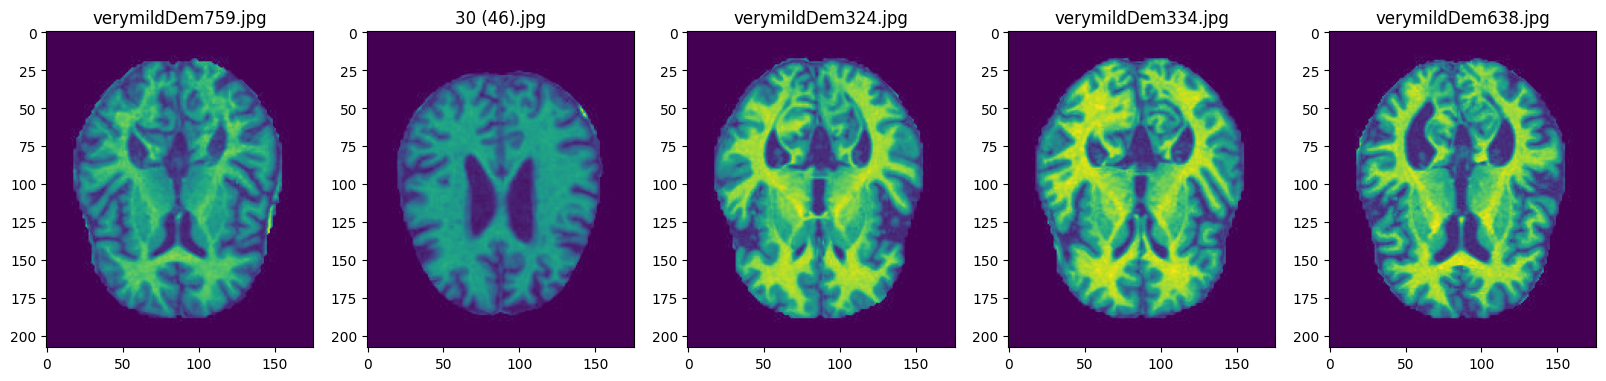

In [6]:
plt.figure(figsize=(20,20))
test_folder=r"/content/drive/MyDrive/Alzheimer_s Dataset/VeryMildDemented"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## Loading data

In [3]:

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
print("load train data set:")
data_ds = image_dataset_from_directory(r"/content/drive/MyDrive/Alzheimer_s Dataset",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE,
                                        color_mode="grayscale",
                                        seed=0)
print("load  data set:")



load train data set:
Found 6400 files belonging to 4 classes.
load  data set:


class names are ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


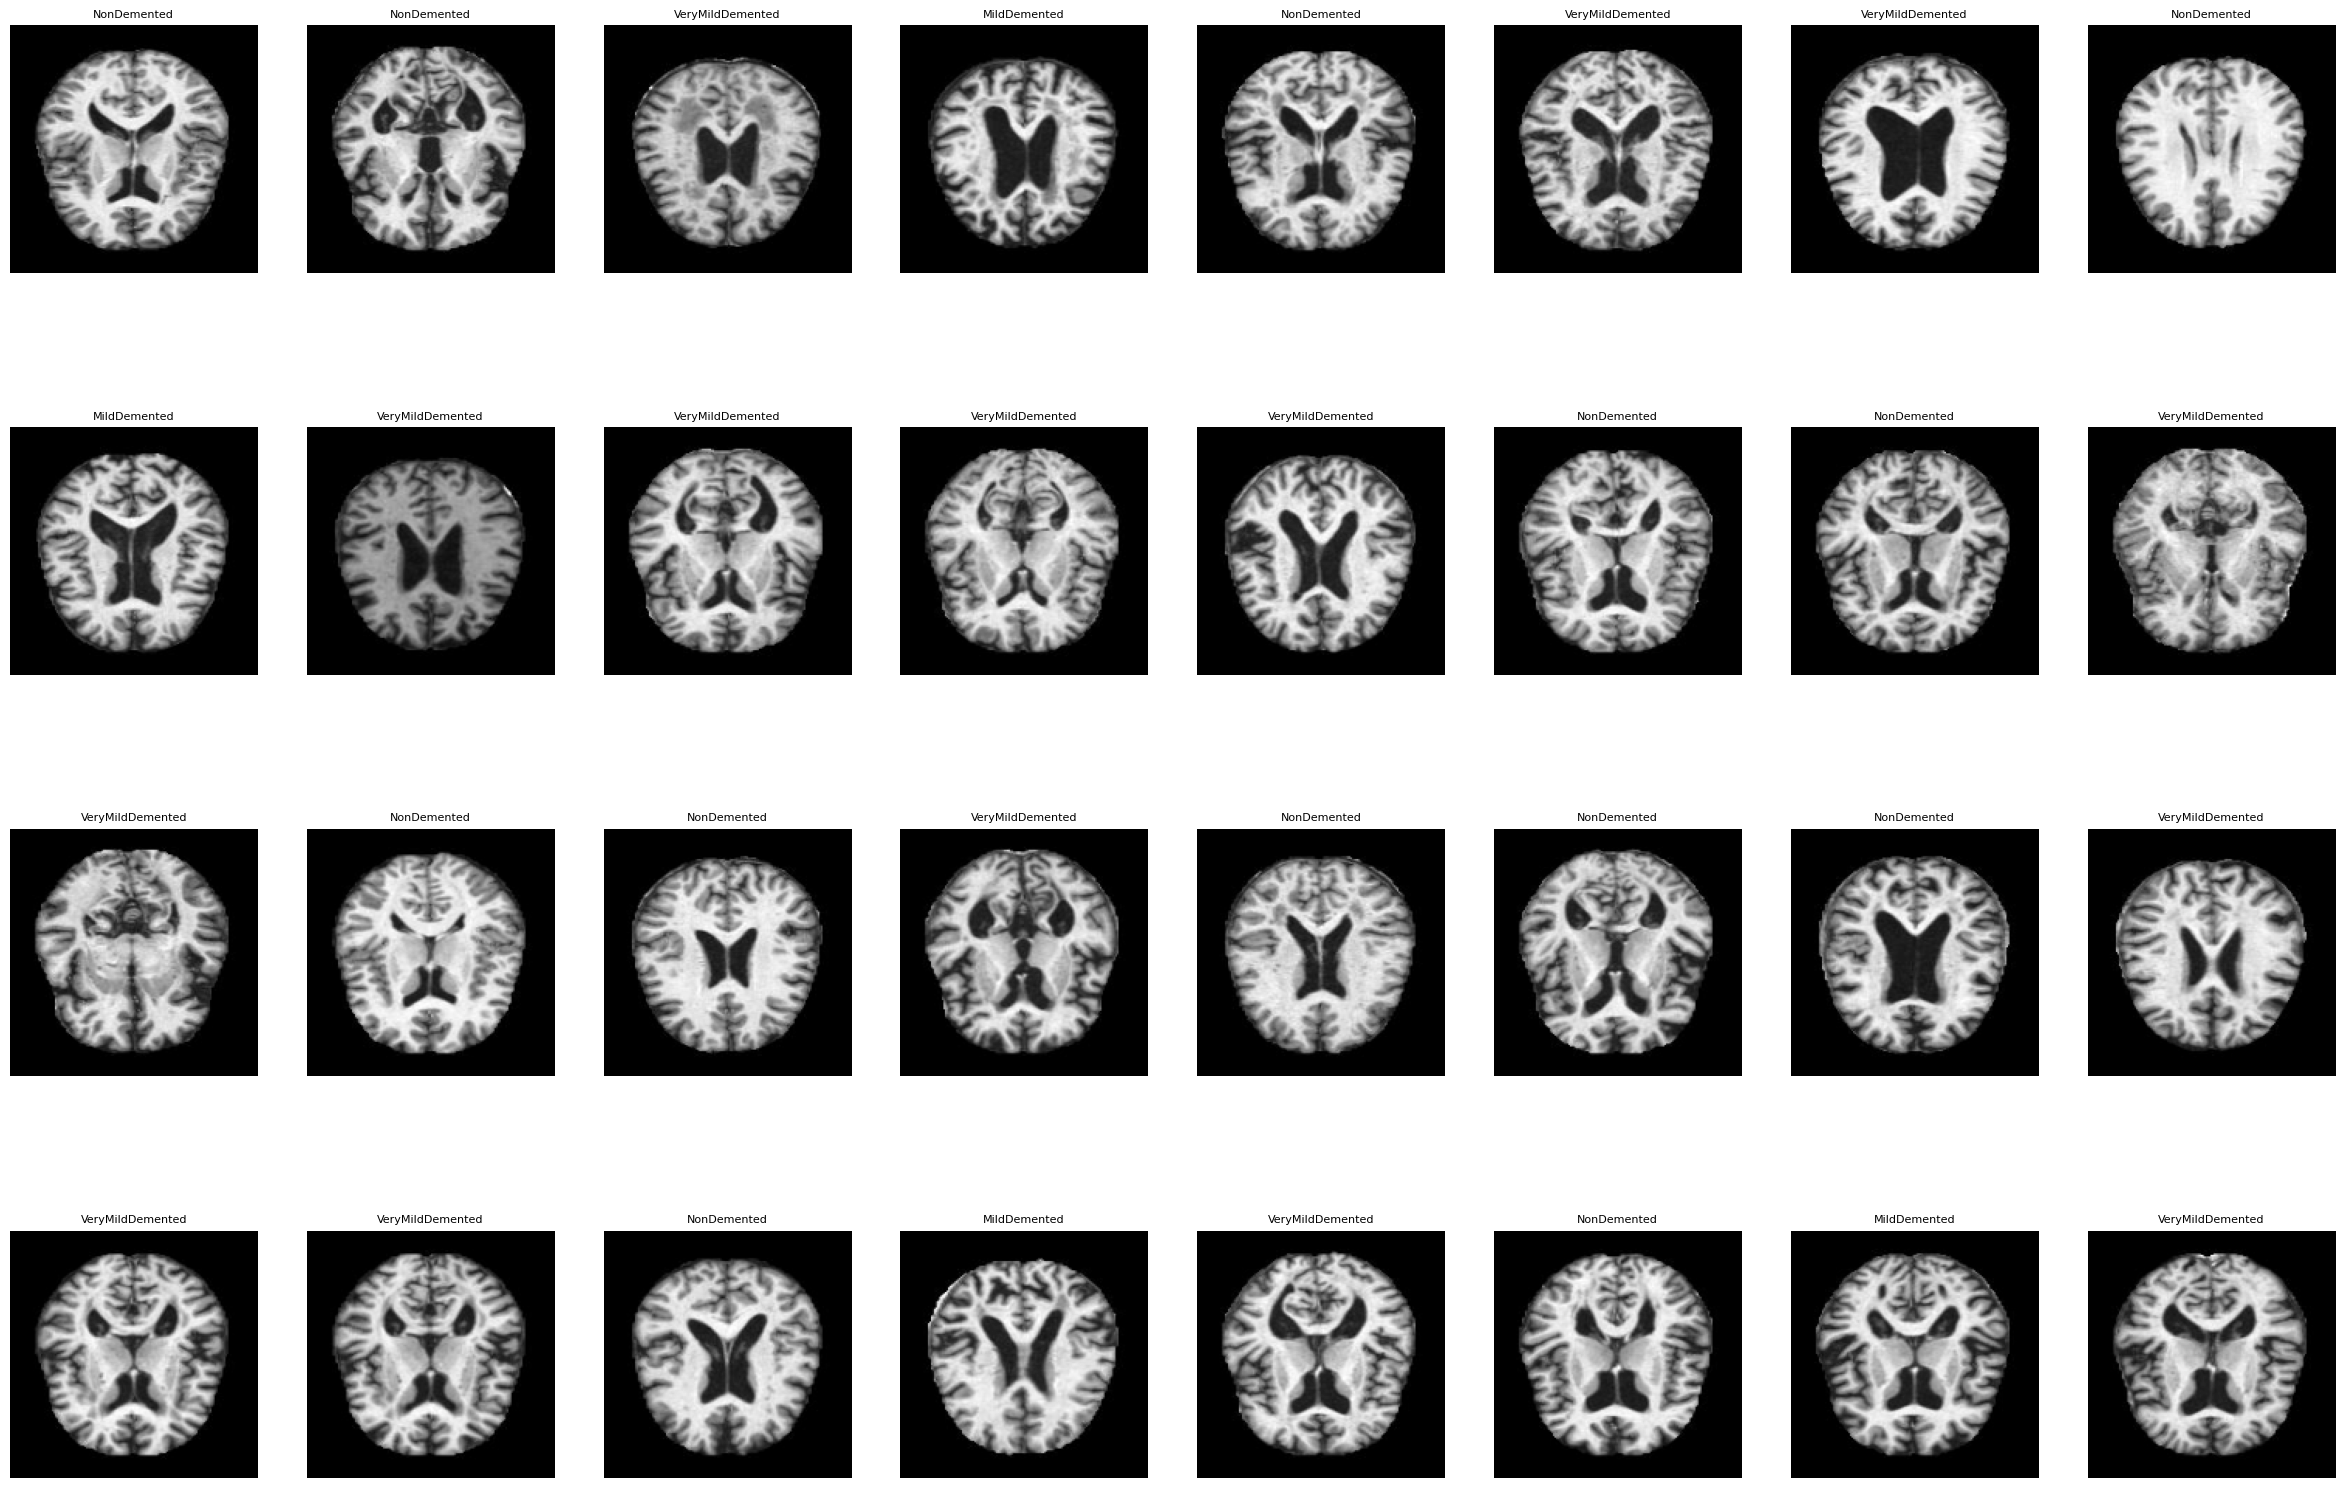

In [4]:


class_names = data_ds.class_names
print(f"class names are {class_names}")
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(30, 20))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

images, labels = next(iter(data_ds))
for i in range(32):
    a = ax.flat[i]
    a.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    a.set_title(class_names[labels[i]],fontsize = 8)
    a.set_axis_off()





# Distribution

In [ ]:


index = np.array([],dtype="int32");
for element in data_ds.as_numpy_iterator():
    index = np.append(index,element[1])

unique, counts = np.unique(index, return_counts=True)
print(counts)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].bar(unique,counts)
ax[0].set_ylabel(f"counts in train data set")
ax[0].set_xticks(np.arange(len(unique)))
ax[0].set_xticklabels([class_names[i] for i in unique], rotation=45, ha='right')

ax[1].pie(counts/counts.sum(), labels=[class_names[i] for i in unique],
          autopct='%1.1f%%',pctdistance=0.5, labeldistance=1.1)


plt.show()



### Data Augmentation


In [5]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   )




In [6]:
imag_size = (176,208)

train_dataset  = train_datagen.flow_from_directory(directory = r"/content/drive/MyDrive/Alzheimer_s Dataset",
                                                   shuffle = True,
                                                   target_size = imag_size,
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 6500
                                                  )


train_data, train_labels = train_dataset.next()

print(train_data.shape, train_labels.shape)

Found 6400 images belonging to 4 classes.
(6400, 176, 208, 3) (6400, 4)


In [7]:
sm = SMOTE(random_state=42)
img_s1 = 176
img_s2 = 208

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, img_s1 * img_s2 * 3), train_labels)

train_data = train_data.reshape(-1, img_s1, img_s2, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 208, 3) (12800, 4)


In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

## Model Building - DenseNet

In [10]:


import ssl

ssl._create_default_https_context = ssl._create_unverified_context
from tensorflow.keras.applications.densenet import DenseNet169

dense = DenseNet169(input_shape=(img_s1,img_s2,3),
                   include_top=False,
                   weights="imagenet")

for layer in dense.layers:
    layer.trainable=False


model = Sequential([
        dense,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ], name = "inception_cnn_model")


model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 5, 6, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 5, 6, 1664)        0         
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 batch_normalization (Batch  (None, 1664)              6656      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)       

### Model Compile

In [11]:



import tensorflow
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRIC = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),]

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)


earlystopping = EarlyStopping(verbose = 1, patience = 40)


callback_list = [earlystopping]


In [12]:


model_history=model.fit(train_data, train_labels,
                        validation_data= (val_data, val_labels),
                        epochs = 100, callbacks = callback_list,
                        )



Epoch 1/100
256/256 [==============================] - 57s 141ms/step - loss: 1.4626 - accuracy: 0.7310 - precision: 0.4345 - recall: 0.2527 - auc: 0.6536 - val_loss: 0.9494 - val_accuracy: 0.8011 - val_precision: 0.7812 - val_recall: 0.2842 - val_auc: 0.8379
Epoch 2/100
256/256 [==============================] - 29s 115ms/step - loss: 1.0200 - accuracy: 0.7909 - precision: 0.6458 - recall: 0.3622 - auc: 0.8105 - val_loss: 0.7492 - val_accuracy: 0.8402 - val_precision: 0.8399 - val_recall: 0.4458 - val_auc: 0.9019
Epoch 3/100
256/256 [==============================] - 29s 114ms/step - loss: 0.8886 - accuracy: 0.8178 - precision: 0.7302 - recall: 0.4302 - auc: 0.8578 - val_loss: 0.6839 - val_accuracy: 0.8512 - val_precision: 0.8298 - val_recall: 0.5093 - val_auc: 0.9158
Epoch 4/100
256/256 [==============================] - 29s 114ms/step - loss: 0.8222 - accuracy: 0.8281 - precision: 0.7599 - recall: 0.4565 - auc: 0.8777 - val_loss: 0.6584 - val_accuracy: 0.8546 - val_precision: 0.8324

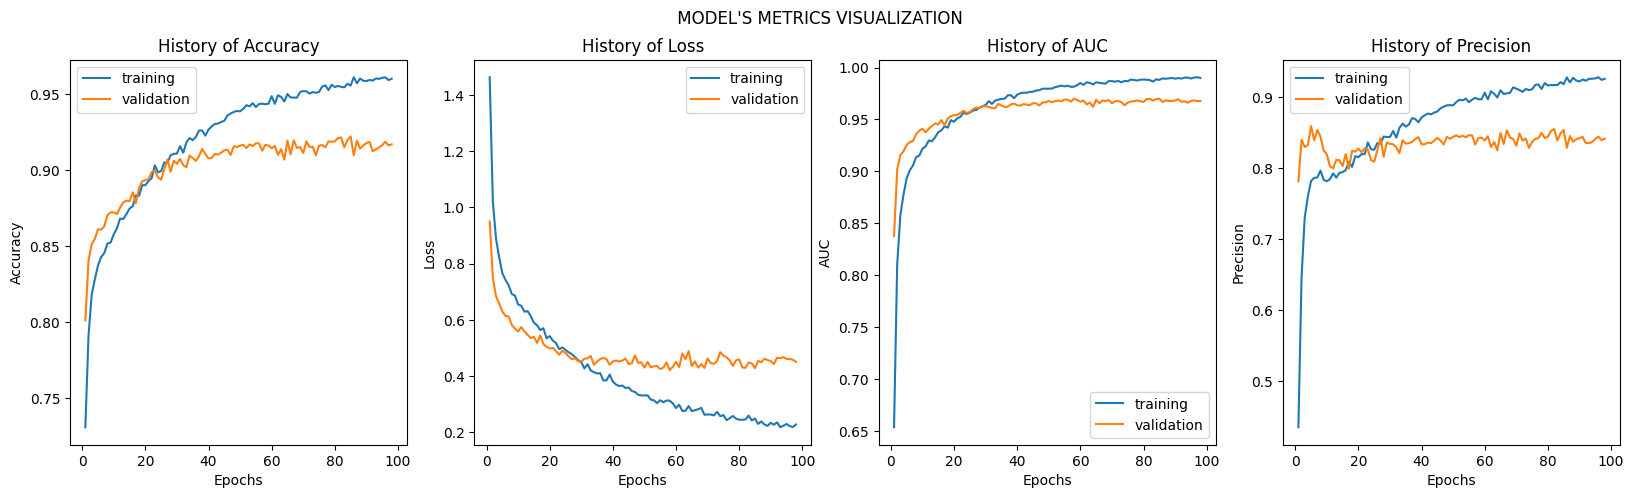

In [13]:



def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):

    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])



    plt.show()


Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision'],

              )






### Prediction and Metrics

80/80 [==============================] - 9s 84ms/step


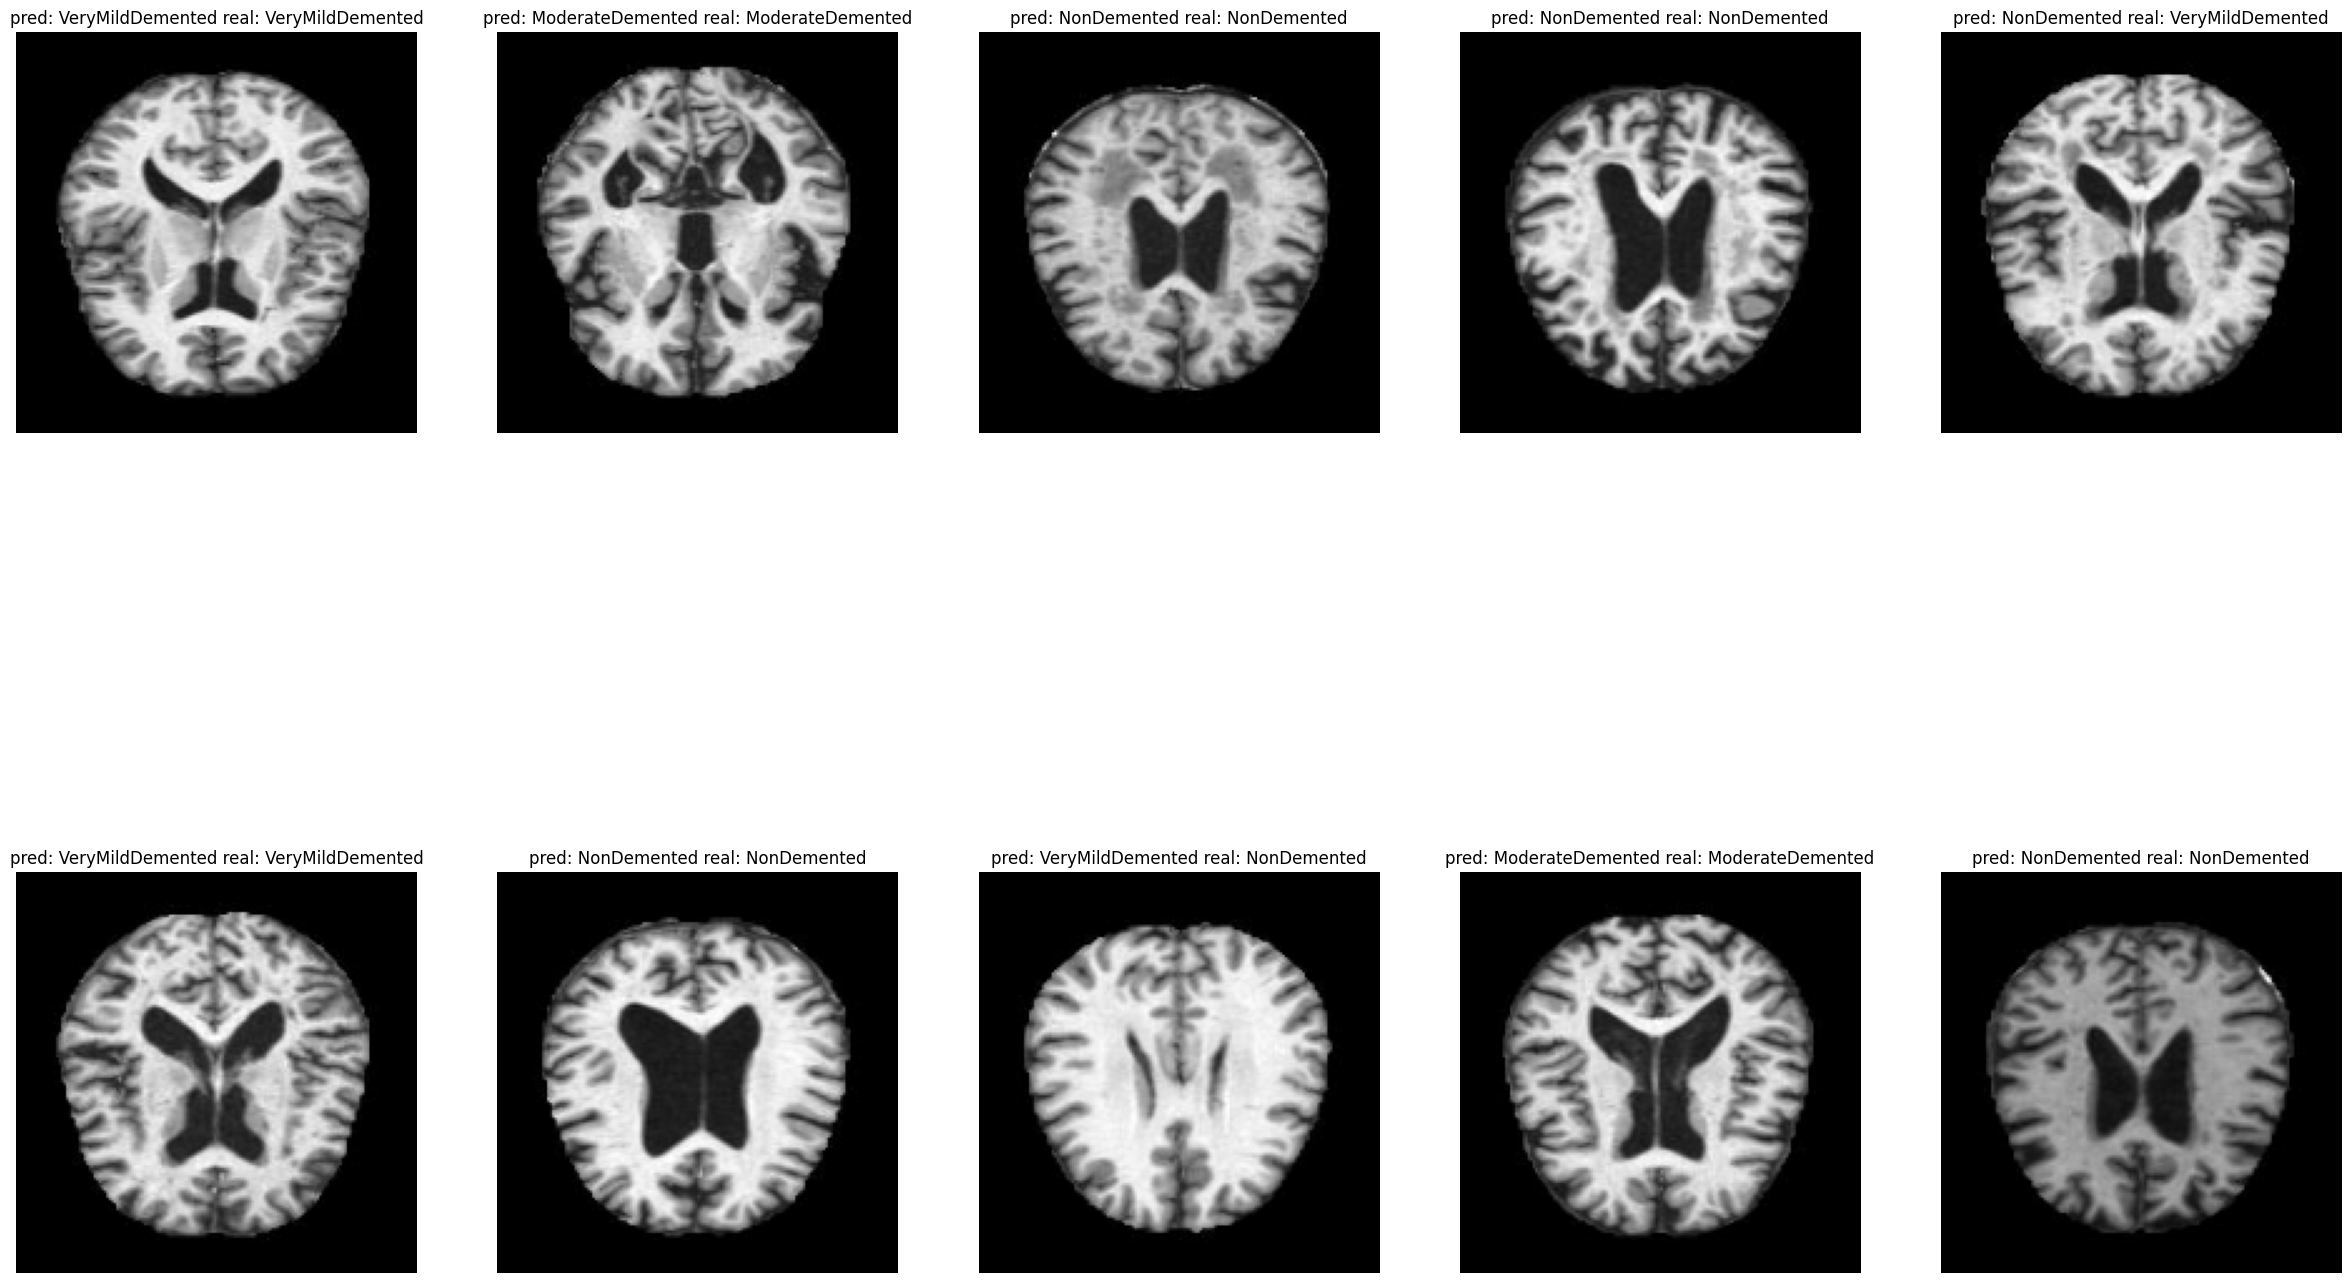

In [14]:
pred_labels= model.predict(test_data)

def roundoff(arr):
  """To round off according to the argmax of each predicted label array. """
  arr[np.argwhere(arr != arr.max())] = 0
  arr[np.argwhere(arr == arr.max())] = 1
  return arr

for labels in pred_labels:
    labels = roundoff(labels)


y_pred = np.argmax(pred_labels, axis=1)
y_test =  np.argmax(test_labels, axis=1)


fig, ax = plt.subplots(nrows=2, ncols=5,figsize=(30, 20))
fig.subplots_adjust(wspace=0.2, hspace=0.2)


for i in range(10):
    a = ax.flat[i]
    a.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    pred_label=y_pred[i]
    actual_label=y_test[i]
    pred_label=class_names[pred_label]
    actual_label=class_names[actual_label]
    label= 'pred: '+ pred_label +' '+'real: '+ actual_label
    a.set_title(label)
    a.set_axis_off()

plt.show()



In [15]:


scores = model.evaluate(test_data, test_labels)


80/80 [==============================] - 7s 87ms/step - loss: 0.4510 - accuracy: 0.9113 - precision: 0.8288 - recall: 0.8133 - auc: 0.9671


In [16]:

print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])



Accuracy =  0.911328136920929
Precision =  0.8288216590881348
Recall =  0.813281238079071
AUC =  0.9671491384506226


In [17]:

from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test, target_names=class_names))

                  precision    recall  f1-score   support

    MildDemented       0.85      0.85      0.85       606
ModerateDemented       1.00      0.99      0.99       641
     NonDemented       0.78      0.74      0.76       731
VeryMildDemented       0.65      0.70      0.67       582

        accuracy                           0.82      2560
       macro avg       0.82      0.82      0.82      2560
    weighted avg       0.82      0.82      0.82      2560



### Confusion matrix

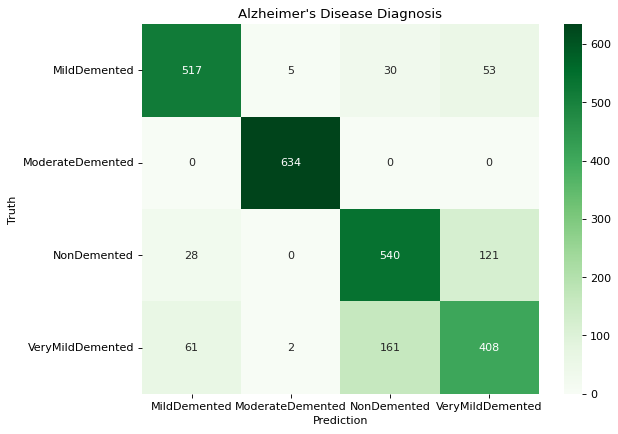

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_arr = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= class_names,
                yticklabels=class_names)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

